In [1]:
# 0. Import Libraries and Load Dataset

# Data analysis and statistics packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, mannwhitneyu, f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Mount Google Drive to access the file
from google.colab import drive
drive.mount('/content/drive')

# Load CSV file with correct delimiter
data_path = "/content/drive/MyDrive/EFIplus_medit_1.csv"
df = pd.read_csv(data_path, sep=';')

# Nice display with pandas Styler (no scroll)
styled_df = (
    df.head(20)
    .style
    .set_caption("🔍 Preview of EFIplus_medit_1 Dataset (First 20 rows)")
    .set_properties(**{
        'background-color': '#f9f9f9',
        'border-color': 'lightgrey',
        'border-style': 'solid',
        'border-width': '1px',
        'text-align': 'center',
        'font-size': '12px'
    })
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]}
    ])
)

styled_df


Mounted at /content/drive


[Z-SCORE] Mean: 0.00, SD: 1.00, 95% CI: [-0.03, 0.03]


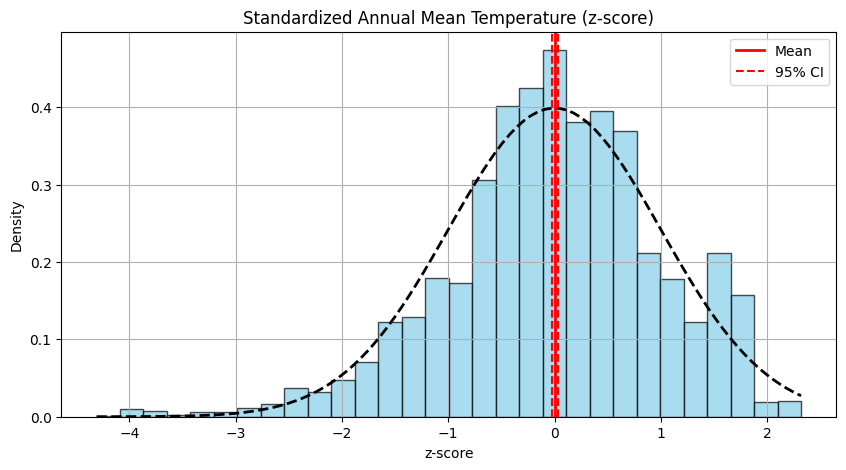

In [ ]:
# 1 — Standardize Annual Mean Temperature (z-score)


# Drop rows with missing temperature
df_clean = df[df['temp_ann'].notna()].copy()

# Z-score standardization
df_clean['temp_ann_z'] = (df_clean['temp_ann'] - df_clean['temp_ann'].mean()) / df_clean['temp_ann'].std()

# Compute statistics
mean_z = df_clean['temp_ann_z'].mean()
std_z = df_clean['temp_ann_z'].std()
n = df_clean['temp_ann_z'].count()
se_z = std_z / np.sqrt(n)

# Confidence Interval (95%)
ci_low = mean_z - 1.96 * se_z
ci_high = mean_z + 1.96 * se_z

print(f"[Z-SCORE] Mean: {mean_z:.2f}, SD: {std_z:.2f}, 95% CI: [{ci_low:.2f}, {ci_high:.2f}]")

# Plot histogram with normal curve and CI
plt.figure(figsize=(10, 5))
plt.hist(df_clean['temp_ann_z'], bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)

# Overlay normal distribution
x = np.linspace(df_clean['temp_ann_z'].min(), df_clean['temp_ann_z'].max(), 100)
plt.plot(x, norm.pdf(x, mean_z, std_z), 'k--', linewidth=2)

# Add mean and CI lines
plt.axvline(mean_z, color='red', linestyle='-', linewidth=2, label='Mean')
plt.axvline(ci_low, color='red', linestyle='--', label='95% CI')
plt.axvline(ci_high, color='red', linestyle='--')

# Final plot settings
plt.title('Standardized Annual Mean Temperature (z-score)')
plt.xlabel('z-score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

=== T-test on raw temp_ann ===
t = -43.960, p = 0.0000

=== T-test on standardized temp_ann_z ===
t = -43.960, p = 0.0000

=== Mann-Whitney U test (non-parametric) ===
U = 1027812, p = 0.0000


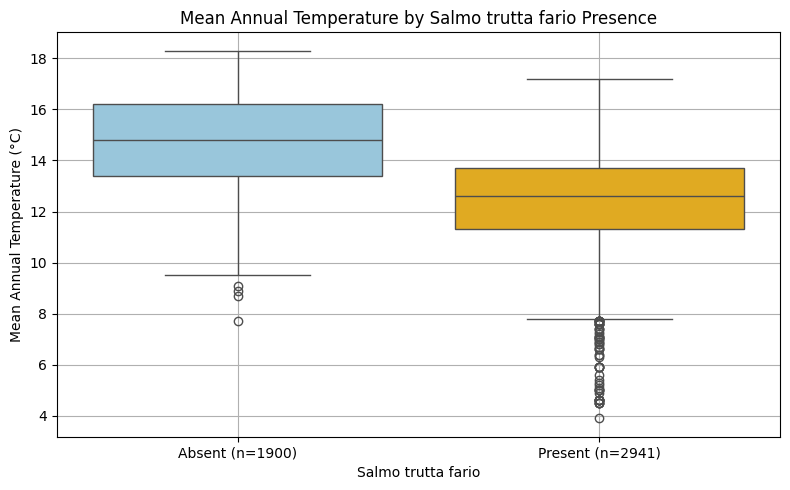

In [2]:
# 2. Test whether the means (or medians) of "temp_ann" differ
# between sites with and without Salmo trutta fario

# Ensure no missing temperature values
df = df[df['temp_ann'].notna()].copy()

# Create z-score column if not already present
df['temp_ann_z'] = (df['temp_ann'] - df['temp_ann'].mean()) / df['temp_ann'].std()

# Create binary variable for presence (1) / absence (0) of Salmo trutta fario
df['salmo_trutta'] = df['Salmo trutta fario'].apply(lambda x: 1 if x > 0 else 0)

# Split into two groups
present = df[df['salmo_trutta'] == 1]
absent = df[df['salmo_trutta'] == 0]


# Parametric t-test on raw values
t_stat_raw, p_val_raw = ttest_ind(present['temp_ann'], absent['temp_ann'], equal_var=False)

# Parametric t-test on standardized values
t_stat_z, p_val_z = ttest_ind(present['temp_ann_z'], absent['temp_ann_z'], equal_var=False)

# Non-parametric test (Mann-Whitney U test)
u_stat, p_u = mannwhitneyu(present['temp_ann'], absent['temp_ann'], alternative='two-sided')


# Print test results
print("=== T-test on raw temp_ann ===")
print(f"t = {t_stat_raw:.3f}, p = {p_val_raw:.4f}")

print("\n=== T-test on standardized temp_ann_z ===")
print(f"t = {t_stat_z:.3f}, p = {p_val_z:.4f}")

print("\n=== Mann-Whitney U test (non-parametric) ===")
print(f"U = {u_stat:.0f}, p = {p_u:.4f}")


# Boxplot: Mean Annual Temperature by Salmo trutta fario presence

# Get sample sizes
n_absent = absent.shape[0]
n_present = present.shape[0]

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='salmo_trutta', y='temp_ann', hue='salmo_trutta', palette=['#8ecae6', '#ffb703'], dodge=False, legend=False)

# Custom X-axis labels with sample sizes
plt.xticks([0, 1], [f'Absent (n={n_absent})', f'Present (n={n_present})'])

plt.title('Mean Annual Temperature by Salmo trutta fario Presence')
plt.xlabel('Salmo trutta fario')
plt.ylabel('Mean Annual Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


***Task 2: Null Hypothesis***

We tested whether the mean annual temperature (`temp_ann`) differs between sampling sites **with** and **without** _Salmo trutta fario_ (Brown Trout).



**Parametric t-test (raw and standardised values):**

- **H₀ (null hypothesis):**  
  The mean annual temperature is the same in sites where _Salmo trutta fario_ is present and where it is absent.

  $$
  H_0: \mu_{\text{present}} = \mu_{\text{absent}}
  $$

- **Result:**  
  The t-test (applied to both raw and z-score standardised values) returned a t-statistic of –43.960 and a p-value < 0.0001.  
  We therefore **reject the null hypothesis** and conclude that the mean annual temperature differs significantly between the two groups.


**Mann-Whitney U test (non-parametric):**

- **H₀ (null hypothesis):**  
  The distribution of mean annual temperature is the same between sites with and without _Salmo trutta fario_.

- **Result:**  
  The Mann-Whitney U statistic was 1,027,812 with a p-value < 0.0001.  
  This confirms a significant difference in distributions, leading us to **reject the null hypothesis** here as well.



**Conclusion:**  
Both parametric and non-parametric tests consistently



=== ANOVA Results ===
                         sum_sq      df           F         PR(>F)
C(Catchment_name)  2.137395e+08     7.0  227.953983  1.369526e-285
Residual           5.315097e+08  3968.0         NaN            NaN

=== Tukey HSD Post-hoc Test ===
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------
  Cantabrica       Catala   50.1883 0.7208  -42.1585  142.5351  False
  Cantabrica        Douro  268.1584    0.0  190.9443  345.3726   True
  Cantabrica         Ebro  467.4299    0.0   399.797  535.0628   True
  Cantabrica Galiza-Norte -184.2794    0.0   -252.02 -116.5388   True
  Cantabrica       Guadia -168.8947    0.0 -251.7428  -86.0466   True
  Cantabrica        Minho  290.9895    0.0  223.2126  358.7663   True
  Cantabrica         Tejo  168.3227    0.0    95.179  241.4664   True
      Catala        Douro  217.9701    0.0  

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Cantabrica,Douro,268.1584,0.0000,190.9443,345.3726,True
2,Cantabrica,Ebro,467.4299,0.0000,399.7970,535.0628,True
3,Cantabrica,Galiza-Norte,-184.2794,0.0000,-252.0200,-116.5388,True
4,Cantabrica,Guadia,-168.8947,0.0000,-251.7428,-86.0466,True
5,Cantabrica,Minho,290.9895,0.0000,223.2126,358.7663,True
6,Cantabrica,Tejo,168.3227,0.0000,95.1790,241.4664,True
7,Catala,Douro,217.9701,0.0000,124.2303,311.7099,True
8,Catala,Ebro,417.2415,0.0000,331.2221,503.2609,True
9,Catala,Galiza-Norte,-234.4677,0.0000,-320.5718,-148.3636,True
10,Catala,Guadia,-219.0831,0.0000,-317.5154,-120.6507,True


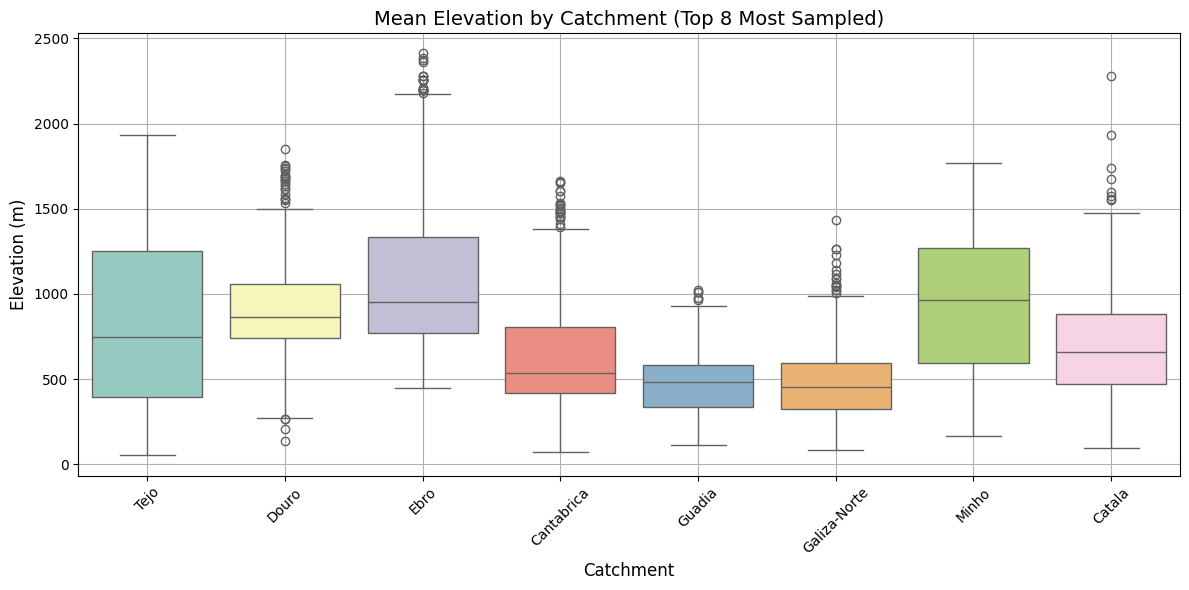

In [3]:
# 3. Test whether there are differences in mean elevation among top 8 catchments

# Remove missing elevation values
df = df[df['Elevation_mean_catch'].notna()].copy()

# Identify the 8 most sampled catchments
top8_catchments = df['Catchment_name'].value_counts().nlargest(8).index.tolist()
df_top8 = df[df['Catchment_name'].isin(top8_catchments)].copy()

# -----------------------------------------------
# One-way ANOVA
model = ols('Elevation_mean_catch ~ C(Catchment_name)', data=df_top8).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("=== ANOVA Results ===")
print(anova_table)

# -----------------------------------------------
# Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(
    endog=df_top8['Elevation_mean_catch'],
    groups=df_top8['Catchment_name'],
    alpha=0.05
)

print("\n=== Tukey HSD Post-hoc Test ===")
print(tukey)

# -----------------------------------------------
# Display only significant differences from Tukey test
tukey_df = pd.DataFrame(
    data=tukey.summary().data[1:],  # skip header row
    columns=tukey.summary().data[0]
)

significant_pairs = tukey_df[tukey_df['reject'] == True]

print("\n=== Significant Pairwise Differences (Tukey HSD) ===")
display(significant_pairs)

# -----------------------------------------------
# Boxplot (with future-proof color fix)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top8,
    x='Catchment_name',
    y='Elevation_mean_catch',
    hue='Catchment_name',
    palette='Set3',
    dodge=False,
    legend=False
)

plt.title("Mean Elevation by Catchment (Top 8 Most Sampled)", fontsize=14)
plt.xlabel("Catchment", fontsize=12)
plt.ylabel("Elevation (m)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
c

***Task 3: Null Hypothesis***

**One-way ANOVA:**

- **H₀ (null hypothesis):**  
  The mean elevation in the upstream catchment (`Elevation_mean_catch`) is equal across all eight most sampled catchments.

  $$
  H_0: \mu_1 = \mu_2 = \dots = \mu_8
  $$

- **Result:**  
  The ANOVA test returned a p-value < 0.0001, indicating a statistically significant difference in mean elevation among the catchments.  
  Therefore, we **reject the null hypothesis**.



**Tukey HSD Post-hoc Test:**

- **H₀ (for each pairwise comparison):**  
  The mean elevation is equal between each pair of catchments being compared.

  $$
  H_0: \mu_i = \mu_j \quad \text{for each pair } (i, j)
  $$

- **Result:**  
  The Tukey HSD test showed that **26 out of 27 pairwise comparisons** exhibited significant differences in elevation (p < 0.05).  
  The only exception was **Cantabrica vs Catala**, where the difference was not statistically significant.  
  We therefore reject the null hypothesis for nearly all catchment pairs.



**Conclusion:**

The one-way ANOVA revealed strong evidence of differences in mean upstream elevation across the eight most sampled catchments (p < 0.0001).  
To identify which groups differed, the Tukey HSD test was applied, confirming that almost all catchment pairs had significantly different mean elevations, except for Cantabrica vs Catala.

These findings are visually supported by the boxplot, which highlights clear differences in elevation distributions between catchments.

**In summary**, upstream elevation differs significantly between most of the major catchments studied, likely reflecting geographic, climatic or topographic variation across regions.




***Task 4: Potential Problems in the Data***

Some issues in the dataset could limit the conclusions from the tests we performed:

- **Uneven sample sizes**: Some catchments or groups had many more observations than others, which can affect the fairness and reliability of the comparisons.

- **Outliers and skewed data**: Variables like elevation and temperature include outliers and are not perfectly normally distributed. This can reduce the accuracy of parametric tests like the t-test or ANOVA.

- **Assumption violations**: We assumed equal variances and independent observations, but those conditions may not be fully met in this dataset.

- **Missing data**: Some observations were excluded due to missing values, which might have introduced bias.

- **No control for other factors**: Other variables (like human impact, habitat type, or geographic differences) might influence the results but were not included in the analysis.

In short, while the tests show statistically significant results, these limitations mean we should be careful when interpreting or generalising the findings.

